### Generating Results from the Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modules import plot_metrics
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import f1_score, classification_report
from itertools import product

In [2]:
# setting global variables
ppc = [(4,4), (8,8), (16,16)]
cpb = [(2,2), (3,3)]
scalers = ['standard', 'minmax', 'robust']
hog_params = [{'pixels_per_cell': i[0],
                   'cells_per_block': i[1]} for i in list(product(ppc, cpb))]
params = list(product(hog_params, scalers))

# metrics for comparison
metrics = ['precision', 'recall', 'f1-score', 'specificity', 'support', 'accuracy']

# import param scores, predicted labels, and compute time
param_scores = np.load('param_f1scores.npy')
predicted_labels = np.load('predicted_labels.npy', allow_pickle=True).item()
computed_time = np.load('computed_time.npy', allow_pickle=True).item()

In [3]:
from scipy.stats import t

def margin_of_error(scores, conf_level=0.95):
    n = len(scores)
    std = np.std(scores)
    t_score = t.ppf(1 - (1-conf_level)/2, df=n-1)
    return t_score * (std/np.sqrt(n))

In [4]:
prms = []
for p in params:
    p = list(p)
    p = [p[0]['pixels_per_cell'], 
         p[0]['cells_per_block'],
         p[1]]
    prms.append(p)

prms = np.array(prms, dtype=object)

for pair in list(product(ppc, cpb)):
    print(f'HOG params: {pair[0]} x {pair[1]}')
    ppc_i = [i for i in range(len(prms[:,0])) if prms[i,0] == pair[0]]
    cpb_i = [i for i in range(len(prms[:,1])) if prms[i,1] == pair[1]]
    idx = [i for i in ppc_i if i in cpb_i]

    print(f' ave. f1-score: {np.mean(param_scores[idx]):0.4f} ± {margin_of_error(param_scores[idx]) :0.4f} \n')

HOG params: (4, 4) x (2, 2)
 ave. f1-score: 0.9534 ± 0.0132 

HOG params: (4, 4) x (3, 3)
 ave. f1-score: 0.9544 ± 0.0136 

HOG params: (8, 8) x (2, 2)
 ave. f1-score: 0.9078 ± 0.0202 

HOG params: (8, 8) x (3, 3)
 ave. f1-score: 0.9085 ± 0.0206 

HOG params: (16, 16) x (2, 2)
 ave. f1-score: 0.9481 ± 0.0172 

HOG params: (16, 16) x (3, 3)
 ave. f1-score: 0.9554 ± 0.0165 



In [5]:
for scl in scalers:
    print(f'Scaler: {scl}')
    idx = np.where(prms[:,2] == scl)[0]
    std = np.std(param_scores[idx])
    t_score = t.ppf(1 - (1-0.95)/2, df=len(param_scores[idx])-1)

    print(f' ave. f1-score: {np.mean(param_scores[idx]):0.4f} ± {margin_of_error(param_scores[idx]) :0.4f} \n')

Scaler: standard
 ave. f1-score: 0.9375 ± 0.0243 

Scaler: minmax
 ave. f1-score: 0.9393 ± 0.0225 

Scaler: robust
 ave. f1-score: 0.9370 ± 0.0233 



In [ ]:
for idx in range(len(params)):
    print(f'Params: {params[idx]}')
    print(f'ave. f1-score: {np.mean(param_scores[idx]):0.4f} ± {margin_of_error(param_scores[idx]):0.4f}')

In [7]:
# pulling best params
ave_scores = np.mean(param_scores, axis=1)
best_idx = np.argsort(ave_scores)[::-1][:2]


params[best_idx[0]], params[best_idx[1]]

(({'pixels_per_cell': (4, 4), 'cells_per_block': (3, 3)}, 'standard'),
 ({'pixels_per_cell': (16, 16), 'cells_per_block': (3, 3)}, 'minmax'))

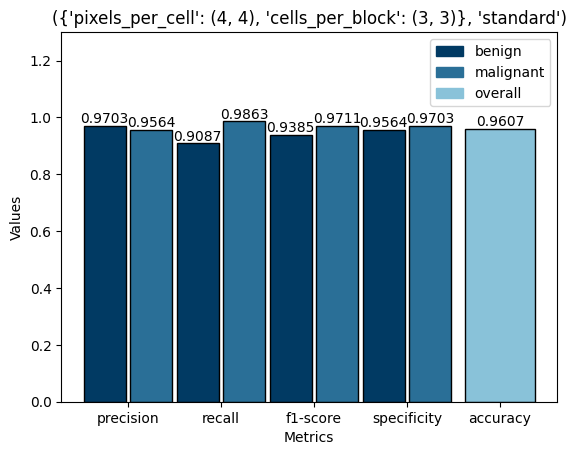

In [8]:
plot_metrics(predicted_labels['phca_bestparam0'],
             predicted_labels['true_labels'],
             metrics, title=params[best_idx[0]], save=False)

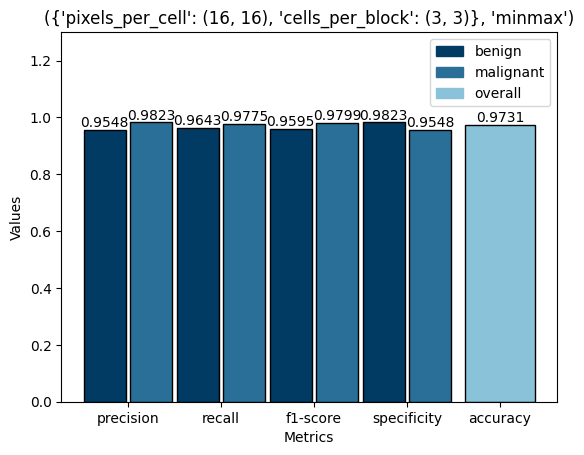

In [10]:
plot_metrics(predicted_labels['phca_bestparam1'],
             predicted_labels['true_labels'],
             metrics, title=params[best_idx[1]], save=False)

In [15]:
for i, idx in enumerate(best_idx):
    print(f"Parameters: {params[idx]}")
    print(f"  data prep: {computed_time[f'bestparam{i}'][0]/60: .4f}")
    print(f"  training: {computed_time[f'bestparam{i}'][1]/60: .4f}")
    print(f"  predicting: {computed_time[f'bestparam{i}'][2]/60: .4f}")
    print(f"  total: {sum(computed_time[f'bestparam{i}'])/60: .4f}")
    print("-"*10)


Parameters: ({'pixels_per_cell': (4, 4), 'cells_per_block': (3, 3)}, 'standard')
  data prep:  17.9672
  training:  0.0564
  predicting:  80.6279
  total:  98.6516
----------
Parameters: ({'pixels_per_cell': (16, 16), 'cells_per_block': (3, 3)}, 'minmax')
  data prep:  2.1420
  training:  0.0569
  predicting:  77.0585
  total:  79.2574
----------


In [22]:
4755.4429 / 5919.0937

0.8034072682444611

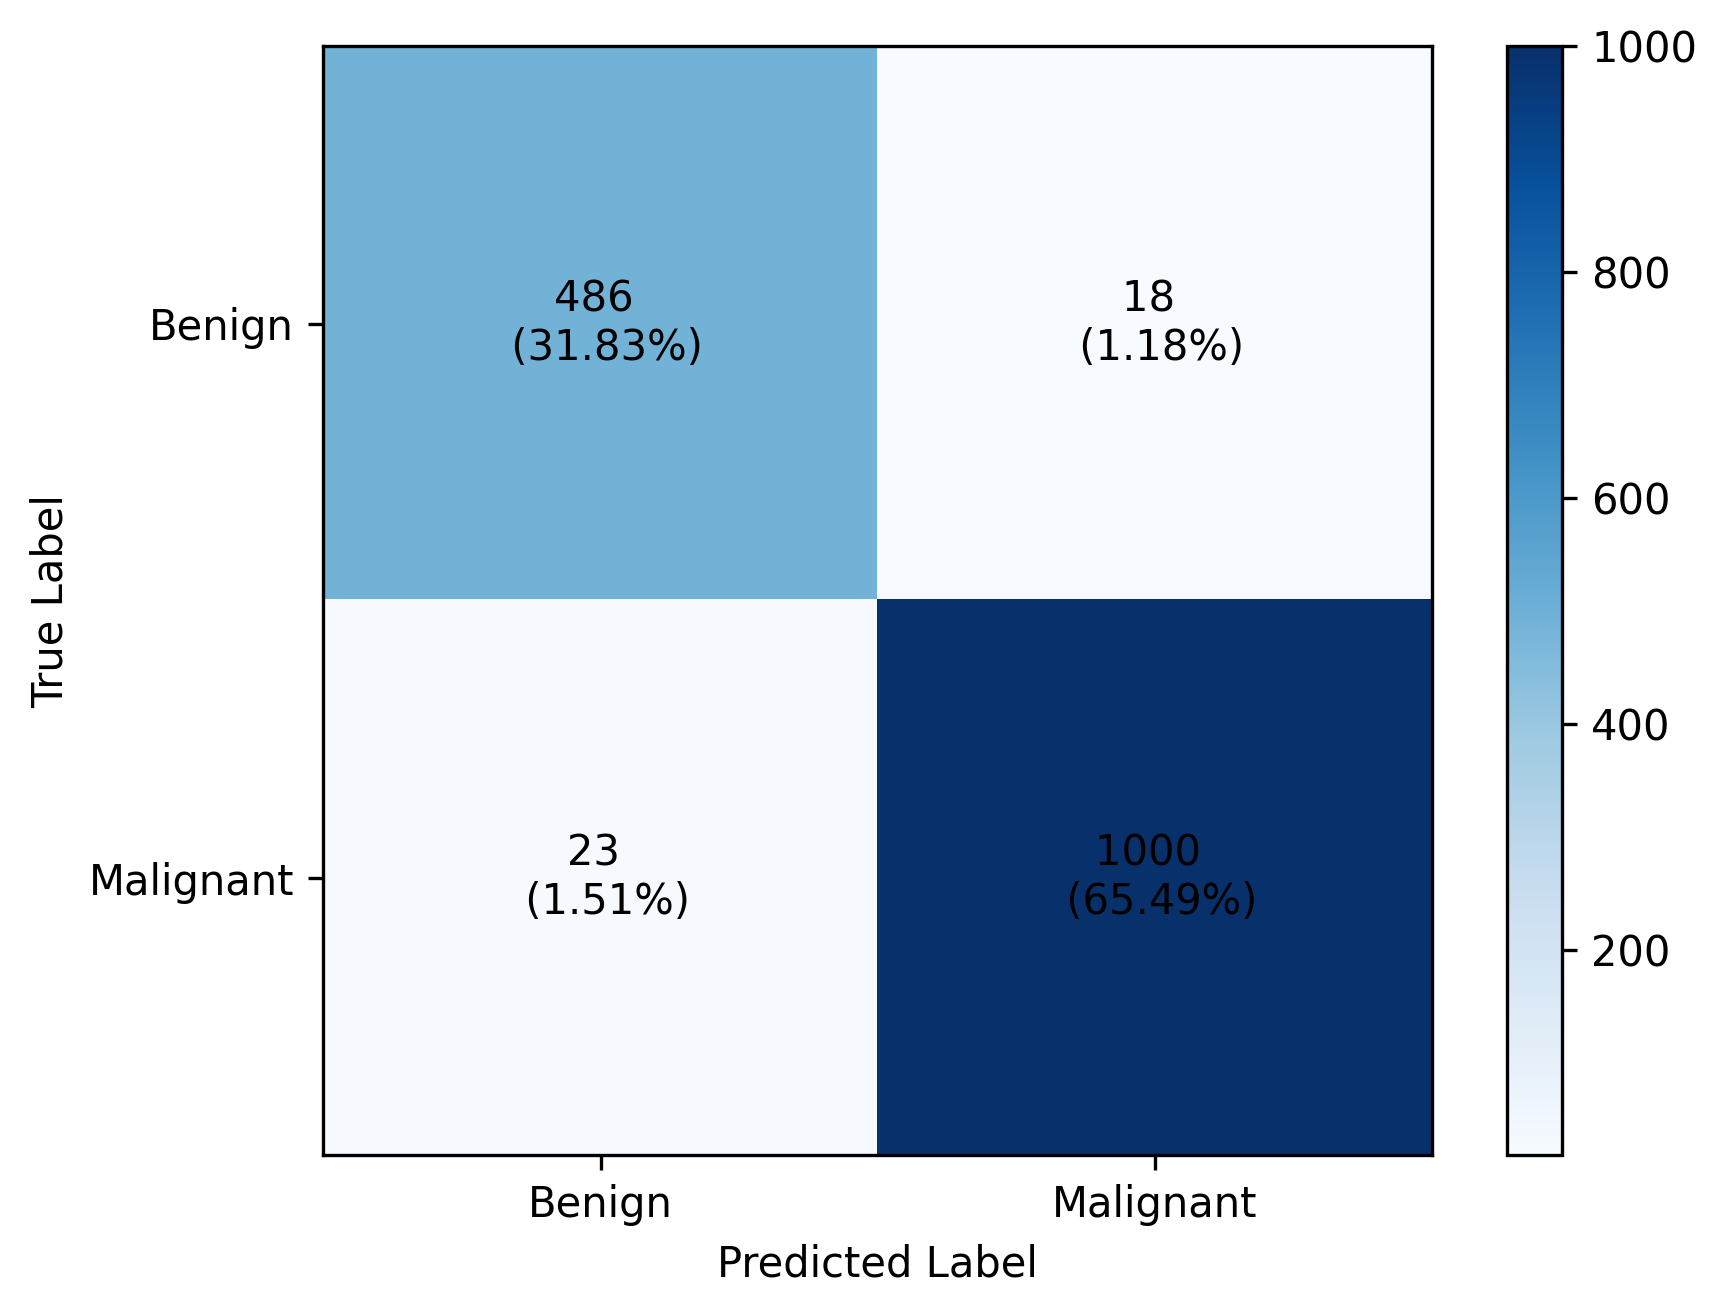

In [44]:
from sklearn.metrics import confusion_matrix


cf = confusion_matrix(predicted_labels['true_labels'],
                      predicted_labels['phca_bestparam1'])
cf_perc = cf / cf.sum() * 100
classes = np.unique(predicted_labels['true_labels'])

# plot matrix with colorbar
plt.rcParams["figure.dpi"] = 300
ax = plt.gca()
im = ax.imshow(cf, cmap='Blues')
plt.colorbar(im)

# axis properties
ax.set_xticks(np.arange(len(classes)), labels=['Benign', 'Malignant'])
ax.set_yticks(np.arange(len(classes)), labels=['Benign', 'Malignant'])
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

# text annotations
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, f"{cf[i,j]} \n ({cf_perc[i,j] :.2f}%)", ha='center', va='center')



In [46]:
print(classification_report(
    predicted_labels['true_labels'],
    predicted_labels['phca_bestparam1']
))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       504
           1       0.98      0.98      0.98      1023

    accuracy                           0.97      1527
   macro avg       0.97      0.97      0.97      1527
weighted avg       0.97      0.97      0.97      1527



### Generate Framework Image

In [65]:
import numpy as np
from skimage.feature import hog
from skimage import exposure

breast_cancer = np.load('breast_cancer_dataset.npy', allow_pickle=True).item()

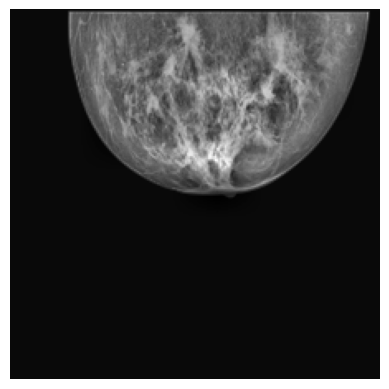

In [84]:
sample_img = breast_cancer['malignantPixels'][9].reshape(224, 224)
plt.imshow(sample_img, cmap='gray')
plt.axis('off')
# plt.margins(0, 0)
# plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

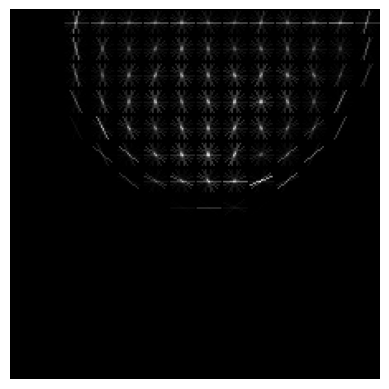

In [85]:
_, hog_img = hog(sample_img, 
                 orientations=9,
                 **params[best_idx[1]][0], 
                 visualize=True)

hog_img_rescaled = exposure.rescale_intensity(hog_img, in_range=(0,50))
plt.imshow(hog_img, cmap='gray')
plt.axis('off');